In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dt
%matplotlib inline
from datetime import datetime
#to plot interactive plots in juoyter notebook
import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
#to detect presence of seasonality in time series data
# from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
#to decompose time series into trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose
#to hide all the warnings
import warnings
warnings.filterwarnings("ignore")

### Reading the csv files

In [245]:
msp_data = pd.read_csv("CMO_MSP_Mandi.csv")
msp_data = msp_data.rename(columns = {'Type' : 'type'})
apmc_data = pd.read_csv("Monthly_data_cmo.csv")
apmc_data = apmc_data.rename(columns = {'APMC' : 'apmc', 'Commodity' : 'commodity', 'Year' :'year','Month' : 'month' })

Making some data adjustments for smooth trend comparison and chart plotting

In [246]:
apmc_data['monthnum'] = apmc_data.month.apply(lambda x: datetime.strptime(x, '%B').strftime('%m')).astype(int)
apmc_data.commodity = apmc_data.commodity.apply(lambda x: x.lower())
msp_data.loc[(msp_data.commodity == 'SUGAR-CANE') | (msp_data.commodity == 'SUGARCANE'), 'commodity'] = 'SUGARCANE'
msp_data.commodity = msp_data.commodity.apply(lambda x: x.lower())

In [247]:
#counting the number of commodities whose msprice is available
len(msp_data.drop_duplicates(['commodity']).merge(apmc_data.drop_duplicates(['commodity']), on = 'commodity', how = 'inner')[['commodity']])

19

### Data Exploration

In [248]:
apmc_data.dtypes

apmc               object
commodity          object
year                int64
month              object
arrivals_in_qtl     int64
min_price           int64
max_price           int64
modal_price         int64
date               object
district_name      object
state_name         object
monthnum            int64
dtype: object

In [249]:
msp_data.head()

,commodity,year,type,msprice,msp_filter
0,paddy-unhusked,2012,Kharif Crops,1250,1
1,rice(paddy-hus),2012,Kharif Crops,1280,1
2,jowar_hybrid,2012,Kharif Crops,1500,1
3,sorgum(jawar),2012,Kharif Crops,1520,1
4,bajri,2012,Kharif Crops,1175,1


In [250]:
apmc_data.describe()

,year,arrivals_in_qtl,min_price,max_price,modal_price,monthnum
count,62429.000000,62429.000000,62429.000000,62429.000000,62429.000000,62429.000000
mean,2015.337503,6043.088324,2945.227587,3688.813628,3296.003989,6.891317
std,0.690451,34703.307427,13183.955730,7662.962469,3607.792534,3.474213
min,2014.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,2015.000000,38.000000,1250.000000,1600.000000,1450.000000,4.000000
50%,2015.000000,211.000000,1976.000000,2797.000000,2425.000000,7.000000
75%,2016.000000,1364.000000,3900.000000,4647.000000,4257.000000,10.000000
max,2016.000000,1450254.000000,3153038.000000,1600090.000000,142344.000000,12.000000


* This shows apmc_data:
 - Has no missing values as every column count is full
 - Year is ranging from 2014 to 2016

In [251]:
msp_data.describe()

,year,msprice,msp_filter
count,155.000000,145.000000,155
mean,2014.000000,2822.448276,1
std,1.418798,1441.725928,0
min,2012.000000,170.000000,1
25%,2013.000000,1470.000000,1
50%,2014.000000,2970.000000,1
75%,2015.000000,4000.000000,1
max,2016.000000,6240.000000,1


* Shows that MSP data:  
    - is available for a time period of 2012 to 2016
    - MSPrices column has 10 missing values

### Treatment of Missing Values
- We can replace a missing value with median or mean, Let's check which one is a better representative of the msprice column
- We will also have to check which commodity has missing values and replace it with that commodity's median/mean only

In [252]:
# Lets start with msp_data
def count_missing_values(x):
    return sum(x.isnull())
msp_data.apply(count_missing_values, axis =0)

commodity      0
year           0
type           0
msprice       10
msp_filter     0
dtype: int64

In [253]:
msp_data[msp_data.msprice.isnull() == True ].isnull().groupby([msp_data['commodity'],msp_data['year']])['msprice'].sum().astype(int)

commodity        year
barli            2016    1
gram_yellow      2016    1
masur_yellow     2016    1
mustard          2016    1
safflower        2016    1
soyabean_black   2015    1
                 2016    1
toria_yellow     2016    1
wheat(husked)    2016    1
wheat(unhusked)  2016    1
Name: msprice, dtype: int64

* Above results states that:
    - Total 10 values are missing from msprice column
    - Missing values are for different commodities
    - Mostly in year 2016, so rather than taking median here, we should use msprice of 2015 as a proxy for year 2016
    - For 'Soyabean_Black', we can use 2014 value

In [254]:
dict_msprice_median = msp_data[(msp_data.year == 2015) & (msp_data.commodity != 'soyabean_black')].groupby(['commodity'])['msprice'].median().to_dict()
dict_msprice_median['soyabean_black'] = msp_data[(msp_data.year == 2014) & (msp_data.commodity == 'soyabean_black')].msprice.tolist()[0]

Lets create a dictionary with only the commodities which have missing values in the data

In [255]:
dict_nullmsprice_median = {}
for key in dict_msprice_median:
    if key in msp_data[msp_data.msprice.isnull() == True].commodity.unique().tolist():
        dict_nullmsprice_median[key] = dict_msprice_median[key]
dict_nullmsprice_median        

{'barli': 1225.0,
 'gram_yellow': 3425.0,
 'masur_yellow': 3325.0,
 'mustard': 3350.0,
 'safflower': 3300.0,
 'soyabean_black': 2500.0,
 'toria_yellow': 3290.0,
 'wheat(husked)': 1525.0,
 'wheat(unhusked)': 1525.0}

In [256]:
for key in dict_nullmsprice_median:
    msp_data[(msp_data.commodity == key) & (msp_data.msprice.isnull() == True)] = msp_data[(msp_data.commodity == key) & (msp_data.msprice.isnull() == True)].fillna(dict_nullmsprice_median[key])

In [257]:
msp_data.apply(count_missing_values)

commodity     0
year          0
type          0
msprice       0
msp_filter    0
dtype: int64

apmc_data missing values treatment

In [258]:
apmc_data.apply(count_missing_values)

apmc               0
commodity          0
year               0
month              0
arrivals_in_qtl    0
min_price          0
max_price          0
modal_price        0
date               0
district_name      0
state_name         0
monthnum           0
dtype: int64

Above result shows that there are no missing values in apmc_data. But we have max_price, min_price & modal_price = 0 in some cases. I would not recommend dropping such rows as that leads to loss of information. So lets replace them with appropriate values

We will use modal price for calculating median of prices across years to find outliers, so lets treat missing values in modal_price first

In [259]:
apmc_data.loc[(apmc_data.modal_price == 0) & (apmc_data.max_price != 0) & (apmc_data.min_price != 0), 'modal_price'] = (apmc_data.max_price + apmc_data.min_price)/2
apmc_data.loc[(apmc_data.modal_price == 0) & (apmc_data.max_price == 0), 'modal_price'] = apmc_data.min_price
apmc_data.loc[(apmc_data.modal_price == 0) & (apmc_data.min_price == 0), 'modal_price'] = apmc_data.max_price
# These 3 conditions should suffice as modal_price is never zero when max and min price are both zero at the same time
apmc_data[apmc_data.modal_price == 0]
#So we can see that all the modal_price = 0 cases have been fixed

,apmc,commodity,year,month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name,monthnum


Lets fix cases where max and min price values are absurd for eg -
- price is zero
- max < min; 
Dropping of columns leads to loss in information, so lets replace these values with an appropriate proxy

In [260]:
apmc_data.loc[(apmc_data.max_price == 0) & (apmc_data.min_price == 0), 'max_price'] = apmc_data.modal_price
apmc_data.loc[(apmc_data.max_price == 0) | (apmc_data.max_price < apmc_data.min_price), 'max_price'] = 2*apmc_data.modal_price - apmc_data.min_price
apmc_data.loc[(apmc_data.min_price == 0), 'min_price'] = 2*apmc_data.modal_price - apmc_data.max_price

apmc_data[(apmc_data.max_price == 0) | (apmc_data.min_price == 0)]
# so we can see that all the max_price and min_price = 0 cases have been fixed

,apmc,commodity,year,month,arrivals_in_qtl,min_price,max_price,modal_price,date,district_name,state_name,monthnum


### Treatment of outliers

Treatment of Outliers doesn't make sense for msp_data as it is declared by govt. So let's treat ouliers in apmc_data

**Note**: Since the data has not yet been treated for seasonality, we will flag outliers in every commodity, apmc combination for every month (dissolving year). Once we get deseasonalised data, we will flag outliers and treat them across every apmc, commodity combination (dissolving year & month)

Approach to identify and treat outliers:
- Calculate mean of modal price for every apmc, commodity combination for every month across years
- Check what values of max_price > (mean + 3std) or min_price < (mean - 3std)
- or we can check values < 5percentile and >95percentile
- Once identified, we will replace outliers with average value in that month

In [261]:
#calculating mean and std for max_price, min_price and modal_price
apmc_max_average_price = apmc_data.groupby(['apmc','commodity','monthnum'])['max_price'].aggregate(['mean','std']).reset_index().fillna(0).rename(columns = {'mean':'mean_max','std': 'std_max'})
apmc_min_average_price = apmc_data.groupby(['apmc','commodity','monthnum'])['min_price'].aggregate(['mean','std']).reset_index().fillna(0).rename(columns = {'mean':'mean_min','std': 'std_min'})
apmc_modal_average_price = apmc_data.groupby(['apmc','commodity','monthnum'])['modal_price'].aggregate(['mean','std']).reset_index().fillna(0).rename(columns = {'mean':'mean_modal','std': 'std_modal'})
apmc_average_price = apmc_data.merge(apmc_max_average_price, on = ['apmc','commodity','monthnum'], how = 'inner')
apmc_average_price = apmc_average_price.merge(apmc_min_average_price,on = ['apmc','commodity','monthnum'], how = 'inner')
apmc_average_price = apmc_average_price.merge(apmc_modal_average_price,on = ['apmc','commodity','monthnum'], how = 'inner')

#Outliers in max_price
apmc_average_price[ apmc_average_price['max_price'] > (apmc_average_price['mean_max'] + (3*apmc_average_price['std_max'])) ]
#Outliers in min_price
apmc_average_price[ apmc_average_price['min_price'] < (apmc_average_price['mean_min'] - (3*apmc_average_price['std_min'])) ]
#outliers in modal_price
apmc_average_price[ apmc_average_price['modal_price'] < (apmc_average_price['mean_modal'] - (3*apmc_average_price['std_modal'])) ]

# #Treatment:
apmc_average_price.max_price[apmc_average_price['max_price'] > (apmc_average_price['mean_max'] + (3*apmc_average_price['std_max']))] = apmc_average_price.mean_max
apmc_average_price.min_price[apmc_average_price['min_price'] < (apmc_average_price['mean_min'] - (3*apmc_average_price['std_min']))] = apmc_average_price.mean_min
apmc_average_price.min_price[apmc_average_price['modal_price'] < (apmc_average_price['mean_modal'] - (3*apmc_average_price['std_modal']))] = apmc_average_price.mean_modal

warnings.filterwarnings("ignore")

### Data Visualisation and Trends

In [280]:
#merging msp_data and apmc_data for the common commodities for ease of comparison
apmc_msp_data = apmc_data.merge(msp_data, on = ['commodity','year'], how = 'inner')
apmc_msp_data ['apmc_comd'] = apmc_msp_data.commodity+'_'+apmc_msp_data.apmc
apmc_msp_data = apmc_msp_data.sort(['apmc_comd','monthnum'])
apmc_msp_data.commodity.unique()

array(['bajri', 'coconut', 'cotton', 'gr.nut kernels', 'maize', 'mustard',
       'niger-seed', 'paddy-unhusked', 'pigeon pea (tur)',
       'rice(paddy-hus)', 'safflower', 'sesamum', 'sorgum(jawar)',
       'spilt gerrn gram', 'split black gram', 'sugarcane', 'sunflower',
       'wheat(husked)', 'wheat(unhusked)'], dtype=object)

So we will Plot arrivals in qtl, modal price and msprice all in one chart for every apmc-commodity cluster and visualize

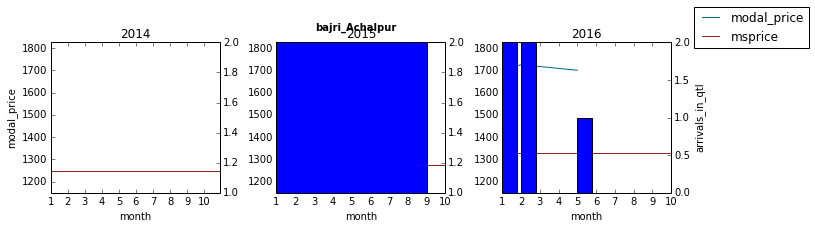

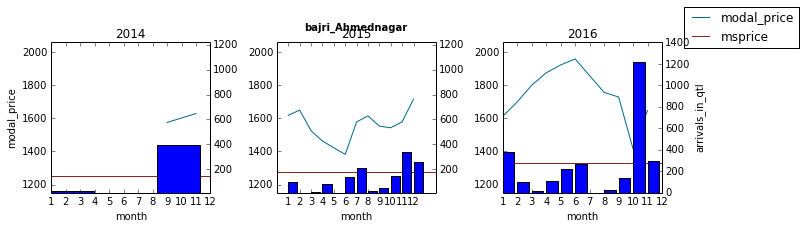

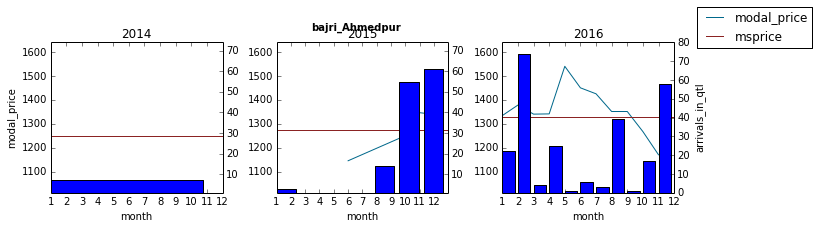

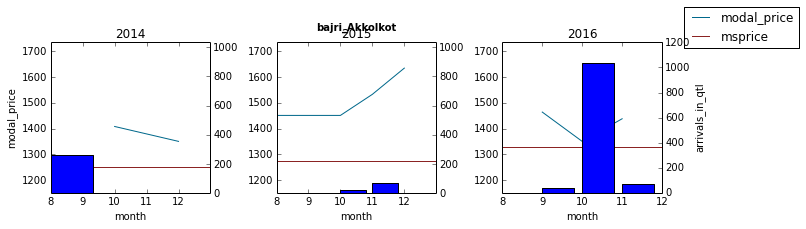

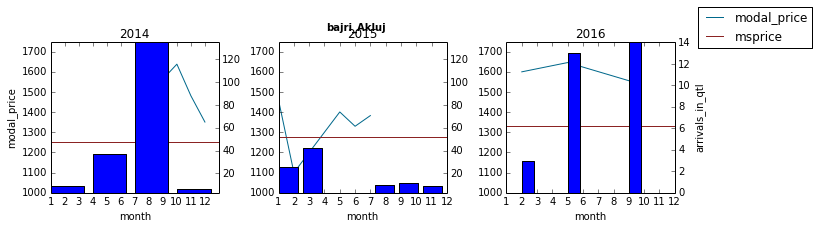

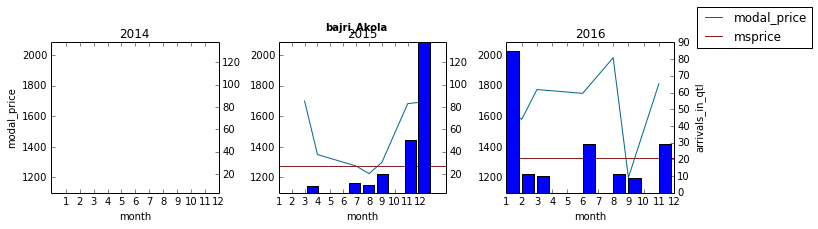

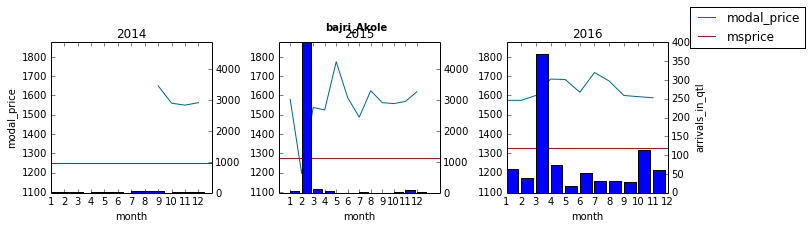

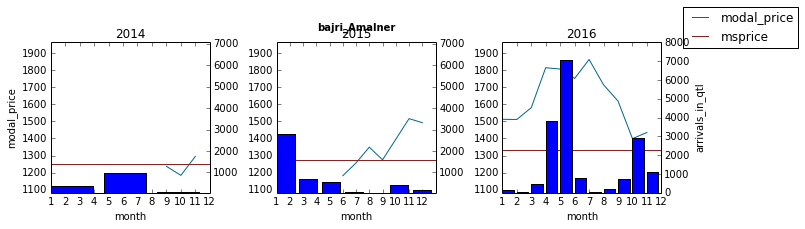

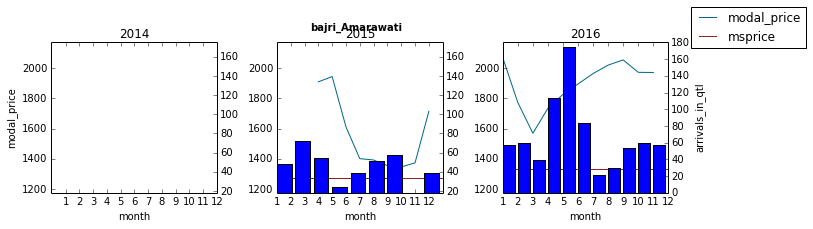

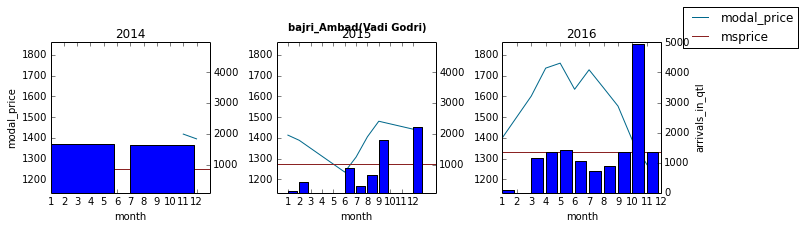

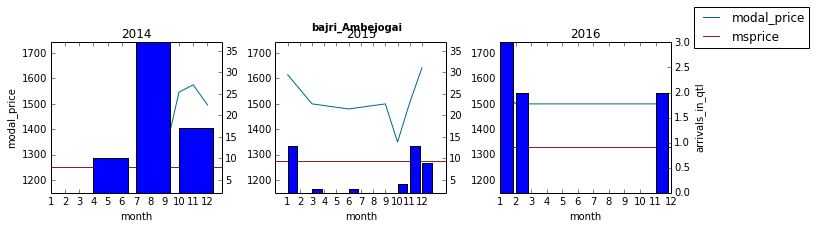

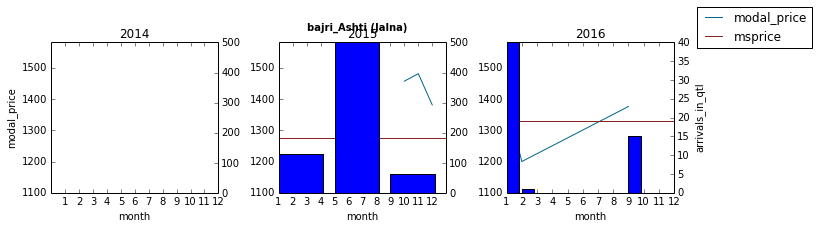

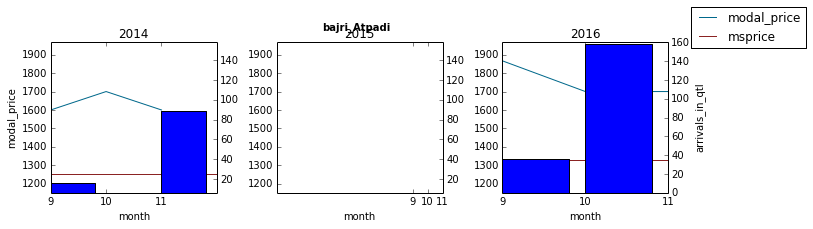

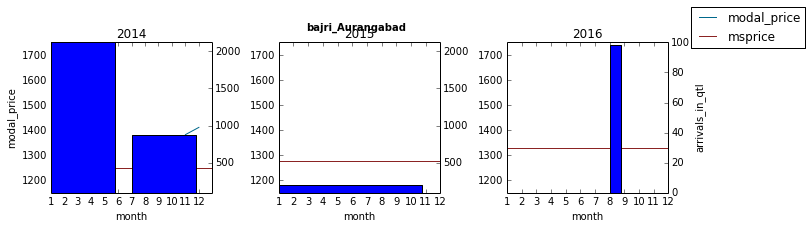

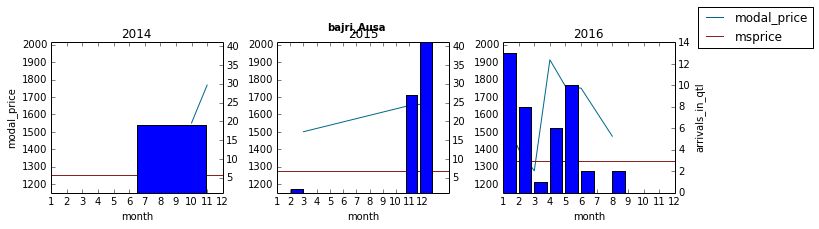

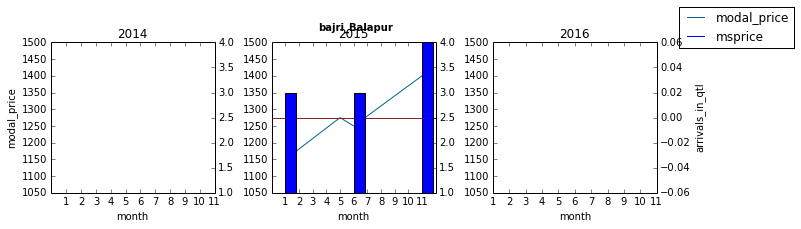

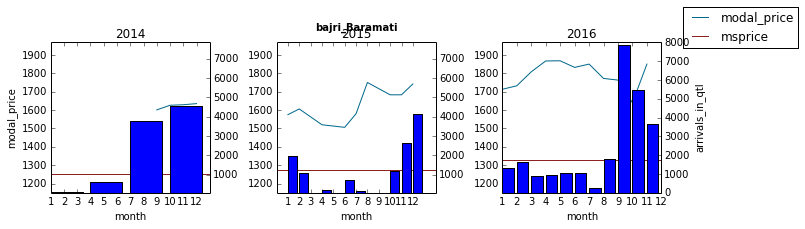

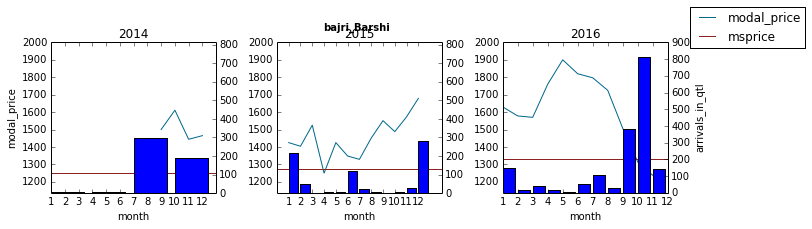

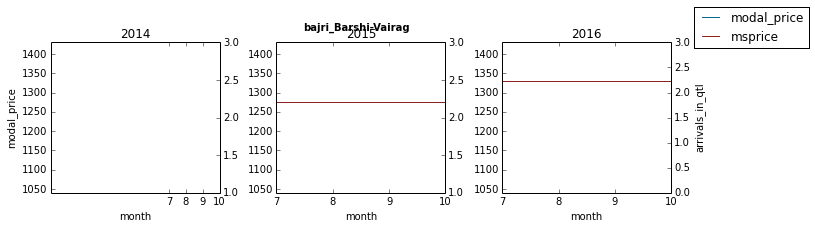

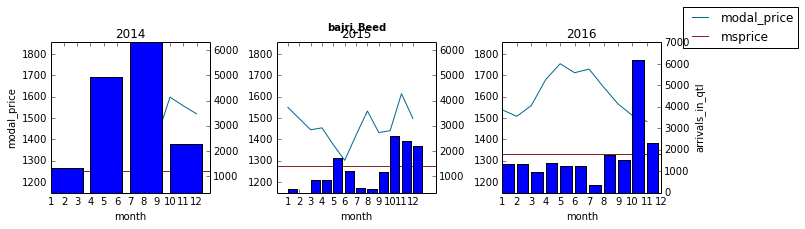

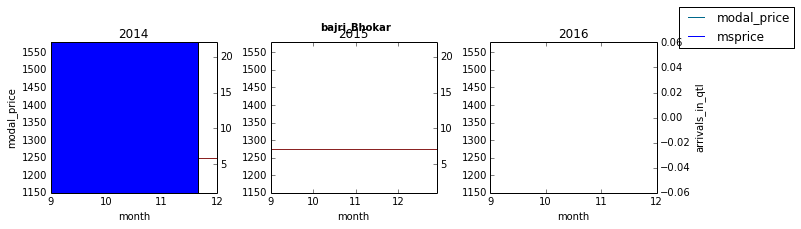

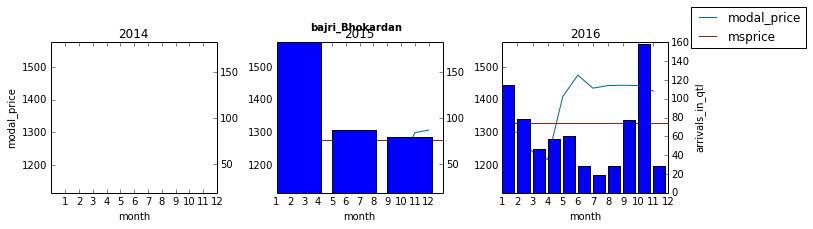

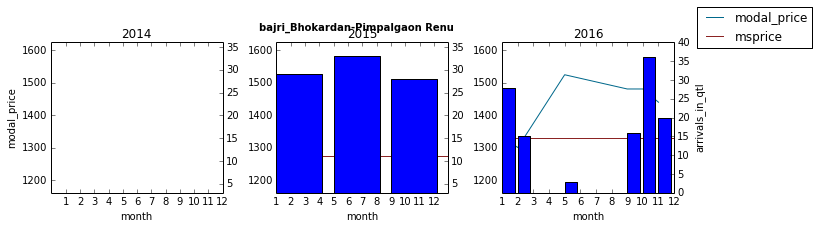

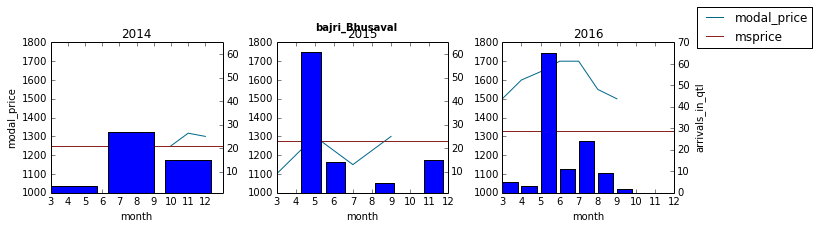

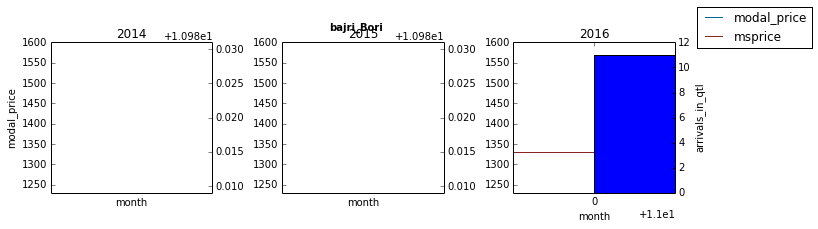

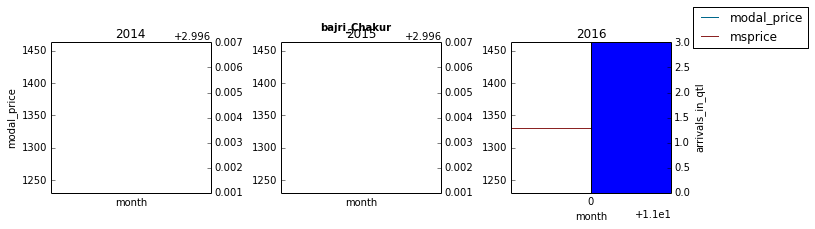

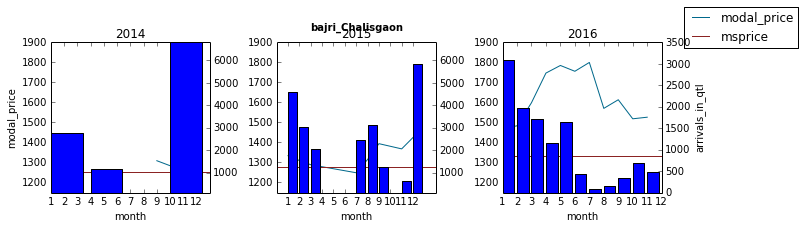

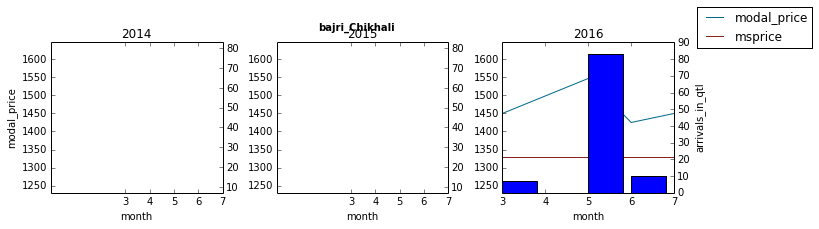

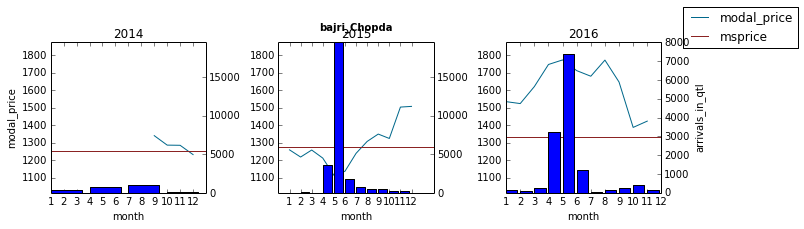

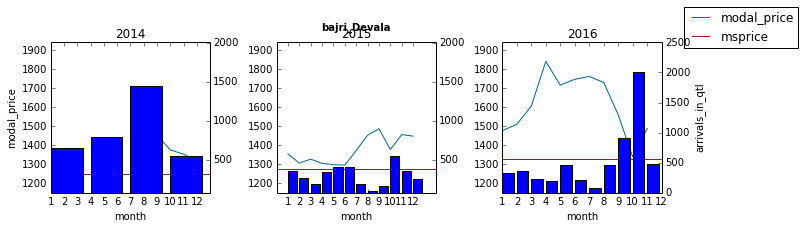

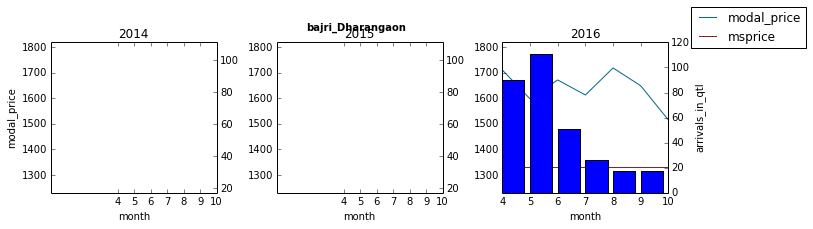

KeyboardInterrupt: 

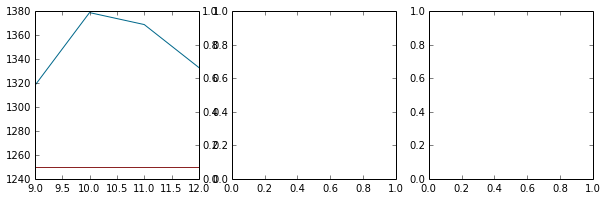

In [263]:
for e in apmc_msp_data.apmc_comd.unique().tolist():
    apmc_comd = apmc_msp_data[(apmc_msp_data.apmc_comd == e)].sort(['monthnum'], ascending = False)
    apmc_comd_2014 = apmc_msp_data[(apmc_msp_data.apmc_comd == e) & (apmc_msp_data.year == 2014)].sort(['monthnum'], ascending = False)
    apmc_comd_2015 = apmc_msp_data[(apmc_msp_data.apmc_comd == e) & (apmc_msp_data.year == 2015)].sort(['monthnum'], ascending = False)
    apmc_comd_2016 = apmc_msp_data[(apmc_msp_data.apmc_comd == e) & (apmc_msp_data.year == 2016)].sort(['monthnum'], ascending = False)

    #initialize the plot
    fig = plt.figure(figsize = (10,3))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    
    #Plot the data
    ax1.plot(apmc_comd_2014.monthnum, apmc_comd_2014.modal_price, color = '#00688B')
    if not apmc_comd_2014.msprice.tolist():
        ax1.axhline(0)
    else:    
        ax1.axhline(apmc_comd_2014.msprice.tolist()[0], color = '#8B2323')
    ax1twinx = ax1.twinx()
    ax1twinx.bar(apmc_comd_2014.monthnum, apmc_comd_2014.arrivals_in_qtl)

    ax2.plot(apmc_comd_2015.monthnum, apmc_comd_2015.modal_price, color = '#00688B')    
    if not apmc_comd_2015.msprice.tolist():
        ax2.axhline(0)
    else:
        ax2.axhline(apmc_comd_2015.msprice.tolist()[0], color = '#8B2323')
    ax2twinx = ax2.twinx()
    ax2twinx.bar(apmc_comd_2015.monthnum, apmc_comd_2015.arrivals_in_qtl)

    ax3.plot(apmc_comd_2016.monthnum, apmc_comd_2016.modal_price, color = '#00688B')
    if not apmc_comd_2016.msprice.tolist():
        ax3.axhline(0)
    else:
        ax3.axhline(apmc_comd_2016.msprice.tolist()[0], color = '#8B2323')
    ax3twinx = ax3.twinx()
    ax3twinx.bar(apmc_comd_2016.monthnum, apmc_comd_2016.arrivals_in_qtl)
    
    #labelling the plot, putting legends and setting axes limits
    xleft , xright = (apmc_comd.monthnum.min(), apmc_comd.monthnum.max())
    ymin = min(apmc_comd[apmc_comd.apmc_comd == e].modal_price.min(), apmc_comd[apmc_comd.apmc_comd == e].msprice.min())
    ymax = max(apmc_comd[apmc_comd.apmc_comd == e].modal_price.max(), apmc_comd[apmc_comd.apmc_comd == e].msprice.max())
    xticks = [i for i in range(xleft, xright+1, 1)]
    ax1.set(title=2014, xlabel="month", ylabel="modal_price", ylim = [ymin-100, ymax+100])
    ax1.xaxis.set(ticks = xticks)
    ax2.set(title=2015, xlabel="month", ylim = [ymin-100, ymax+100] )
    ax2.xaxis.set(ticks = xticks)
    ax3.set(title=2016, xlabel="month", ylim = [ymin-100, ymax+100] )
    ax3.xaxis.set(ticks = xticks)
    ax3.legend(['modal_price', 'msprice'], loc='center left', bbox_to_anchor=(1.10, 1.10))
    
    ymins, ymaxs = (apmc_comd[apmc_comd.apmc_comd == e].arrivals_in_qtl.min(), apmc_comd[apmc_comd.apmc_comd == e].arrivals_in_qtl.max())     
    ax1twinx.set_ylim(ymins, ymaxs)    
    ax2twinx.set_ylim(ymins, ymaxs)    
    ax2twinx.set_ylim(ymins, ymaxs)
    ax3twinx.set_ylabel("arrivals_in_qtl")

        
    
    #showing the plot with tight layout
    fig.suptitle(e, fontsize = 10, fontweight='bold')
    plt.xlim(xleft, xright)
    fig.subplots_adjust(top=0.9)
    plt.tight_layout()
    plt.show()


#### Interactive model of the same plot providing liberty to analyse range of months and one commodity_apmc at a time

In [264]:
def plot_bar_chart(monthnum, cmd_apmc):
    apmc_comd = apmc_msp_data[(apmc_msp_data.apmc_comd == cmd_apmc) & (apmc_msp_data.monthnum >= monthnum[0]) & (apmc_msp_data.monthnum <= monthnum[1])].sort(['monthnum'], ascending = False)
    apmc_comd_2014 = apmc_msp_data[(apmc_msp_data.apmc_comd == cmd_apmc) & (apmc_msp_data.year == 2014) & (apmc_msp_data.monthnum >= monthnum[0]) & (apmc_msp_data.monthnum <= monthnum[1])].sort(['monthnum'], ascending = False)
    apmc_comd_2015 = apmc_msp_data[(apmc_msp_data.apmc_comd == cmd_apmc) & (apmc_msp_data.year == 2015) &  (apmc_msp_data.monthnum >= monthnum[0]) & (apmc_msp_data.monthnum <= monthnum[1])].sort(['monthnum'], ascending = False)
    apmc_comd_2016 = apmc_msp_data[(apmc_msp_data.apmc_comd == cmd_apmc) & (apmc_msp_data.year == 2016) & (apmc_msp_data.monthnum >= monthnum[0]) & (apmc_msp_data.monthnum <= monthnum[1])].sort(['monthnum'], ascending = False)

    #initialize the plot
    fig = plt.figure(figsize = (10,3))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133)
    
    #Plot the data
    ax1.plot(apmc_comd_2014.monthnum, apmc_comd_2014.modal_price, color = '#00688B')
    if not apmc_comd_2014.msprice.tolist():
        ax1.axhline(0)
    else:    
        ax1.axhline(apmc_comd_2014.msprice.tolist()[0], color = '#8B2323')
    ax1twinx = ax1.twinx()
    ax1twinx.bar(apmc_comd_2014.monthnum, apmc_comd_2014.arrivals_in_qtl)

    ax2.plot(apmc_comd_2015.monthnum, apmc_comd_2015.modal_price, color = '#00688B')    
    if not apmc_comd_2015.msprice.tolist():
        ax2.axhline(0)
    else:
        ax2.axhline(apmc_comd_2015.msprice.tolist()[0], color = '#8B2323')
    ax2twinx = ax2.twinx()
    ax2twinx.bar(apmc_comd_2015.monthnum, apmc_comd_2015.arrivals_in_qtl)

    ax3.plot(apmc_comd_2016.monthnum, apmc_comd_2016.modal_price, color = '#00688B')
    if not apmc_comd_2016.msprice.tolist():
        ax3.axhline(0)
    else:
        ax3.axhline(apmc_comd_2016.msprice.tolist()[0], color = '#8B2323')
    ax3twinx = ax3.twinx()
    ax3twinx.bar(apmc_comd_2016.monthnum, apmc_comd_2016.arrivals_in_qtl)
    
    #labelling the plot, putting legends and setting axes limits
    xleft , xright = (apmc_comd.monthnum.min(), apmc_comd.monthnum.max())
    ymin = min(apmc_comd[apmc_comd.apmc_comd == cmd_apmc].modal_price.min(), apmc_comd[apmc_comd.apmc_comd == cmd_apmc].msprice.min())
    ymax = max(apmc_comd[apmc_comd.apmc_comd == cmd_apmc].modal_price.max(), apmc_comd[apmc_comd.apmc_comd == cmd_apmc].msprice.max())
    xticks = [i for i in range(xleft, xright+1, 1)]
    ax1.set(title=2014, xlabel="month", ylabel="modal_price", ylim = [ymin-100, ymax+100])
    ax1.xaxis.set(ticks = xticks)
    ax2.set(title=2015, xlabel="month", ylim = [ymin-100, ymax+100] )
    ax2.xaxis.set(ticks = xticks)
    ax3.set(title=2016, xlabel="month", ylim = [ymin-100, ymax+100] )
    ax3.xaxis.set(ticks = xticks)

    ax3.legend(['modal_price', 'msprice'], loc='center left', bbox_to_anchor=(1.10, 1.15))
    
    ymins, ymaxs = (apmc_comd[apmc_comd.apmc_comd == cmd_apmc].arrivals_in_qtl.min(), apmc_comd[apmc_comd.apmc_comd == cmd_apmc].arrivals_in_qtl.max())     
    ax1twinx.set_ylim(ymins, ymaxs)    
    ax2twinx.set_ylim(ymins, ymaxs)    
    ax2twinx.set_ylim(ymins, ymaxs)
    ax3twinx.set_ylabel("arrivals_in_qtl")
    
    
    #showing the plot with tight layout
    plt.xlim(xleft, xright)
    fig.subplots_adjust(top=0.9)
    plt.tight_layout()
    plt.show()

interact(plot_bar_chart, monthnum = widgets.IntRangeSlider(
    value=[2,12],
    min=1,
    max=12,
    step=1,
    description='Month:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    ), cmd_apmc = widgets.Dropdown(
    options=apmc_msp_data.apmc_comd.unique().tolist(),
    value='bajri_Ahmednagar',
    description='cmd_apmc:',
    disabled=False,
))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEludFJhbmdlU2xpZGVyKHZhbHVlPSgyLCAxMiksIGNvbnRpbnVvdXNfdXBkYXRlPUZhbHNlLCBkZXNjcmlwdGlvbj11J01vbnRoOicsIG1heD0xMiwgbWnigKY=


<function __main__.plot_bar_chart>

In [281]:
apmc_msp_data[['date_revised']] = apmc_msp_data[['date']].applymap(lambda x: datetime.strptime(x, '%Y-%m').date())

In [266]:
def plot_line_chart(cmd_apmc, yaxis):
    apmc_comd = apmc_msp_data[apmc_msp_data.apmc_comd == cmd_apmc].sort(['year','monthnum'])
    
    #initialize the plot
    fig = plt.figure(figsize = (13,3))
    ax1 = fig.add_subplot(111)
    xax = plt.gca().get_xaxis()
    xax.set_major_formatter(dt.DateFormatter('%Y-%m'))
    
    #plot the data
    ax1.plot(apmc_comd.date_revised, apmc_comd.modal_price)
            
    if yaxis == 'arrivals_in_qtl':
        ax2 = ax1.twinx()
        ax2.plot(apmc_comd.date_revised, apmc_comd.arrivals_in_qtl, linestyle='--')
        ax1.legend(['modal_price'], loc= 'upper left')
        ax2.legend(loc= 'upper right')
        ax2.set(ylabel = 'arrivals_in_qtl')
    if yaxis == 'msprice':
        ax1.plot(apmc_comd.date_revised, apmc_comd.msprice)
        ax1.legend(['modal_price',yaxis], loc = 'upper left')
    if yaxis == 'max_price':
        ax1.plot(apmc_comd.date_revised, apmc_comd.max_price)
        ax1.legend(['modal_price',yaxis], loc = 'upper left')
    if yaxis == 'min_price':
        ax1.plot(apmc_comd.date_revised, apmc_comd.min_price)
        ax1.legend(['modal_price',yaxis], loc = 'upper left')
    
    #Plotting vertical to separate different years
    for i in range(1, 12, 1):
        if '2015-0'+str(i) in apmc_comd.date.tolist():
            ax1.axvline(x= '2015-0'+str(i), linewidth = .2)
            break
    for i in range(1, 12, 1):
        if '2016-0'+str(i) in apmc_comd.date.tolist():
            ax1.axvline(x= '2016-0'+str(i), linewidth = .2)
            break

    ax1.set(ylabel = 'price')
           
    #defining layout of the plot
    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)
    plt.show()

interact(plot_line_chart, cmd_apmc= widgets.Dropdown(
    options=apmc_msp_data.apmc_comd.unique().tolist(),
    value='bajri_Ahmednagar',
    description='cmd_apmc:',
    disabled=False,
), yaxis = widgets.ToggleButtons(
    options=['arrivals_in_qtl','msprice','max_price', 'min_price'],
    description='yaxis:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Appears on the secondary axis','', '', ''],
) ) 

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnY21kX2FwbWM6JywgaW5kZXg9MSwgb3B0aW9ucz0oJ2JhanJpX0FjaGFscHVyJywgJ2JhanJpX0FobWVkbmFnYXLigKY=


<function __main__.plot_line_chart>

Plotting all the variables together in the above plot to analyse at one go

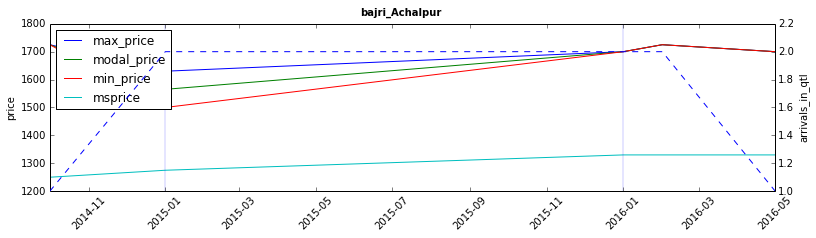

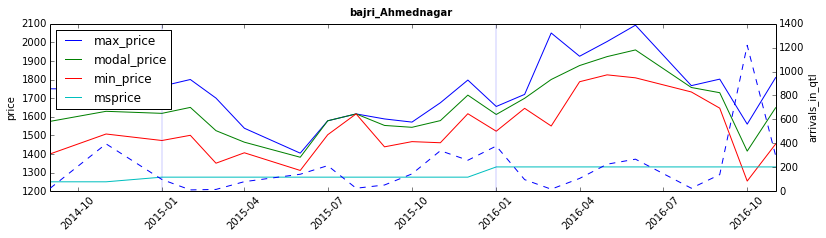

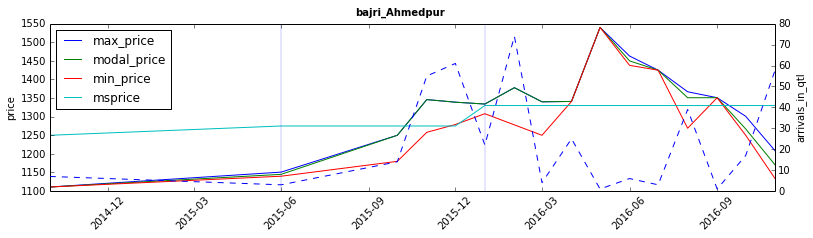

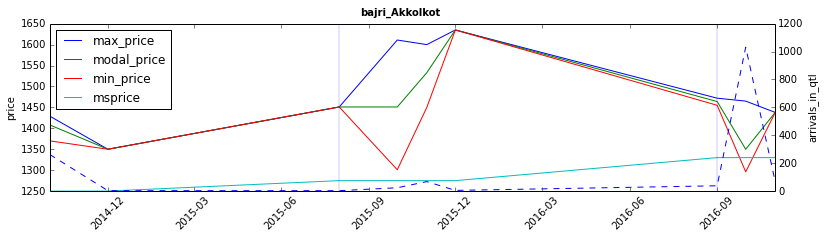

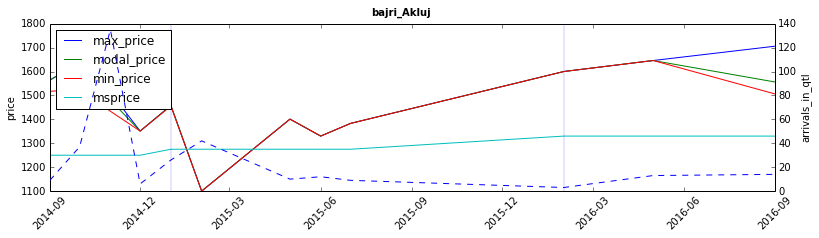

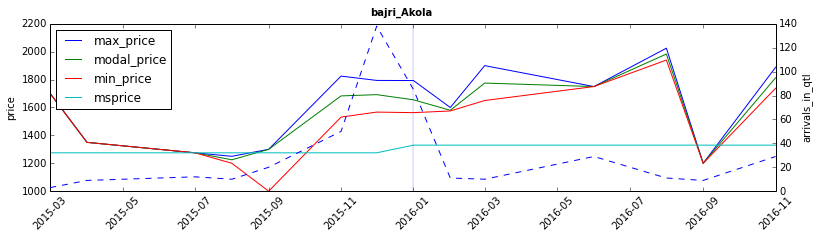

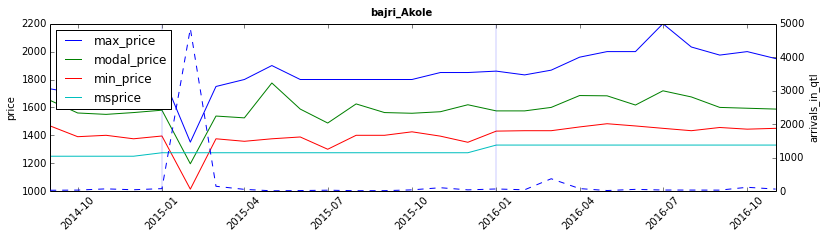

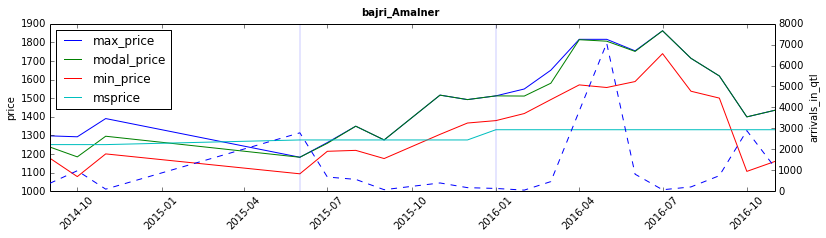

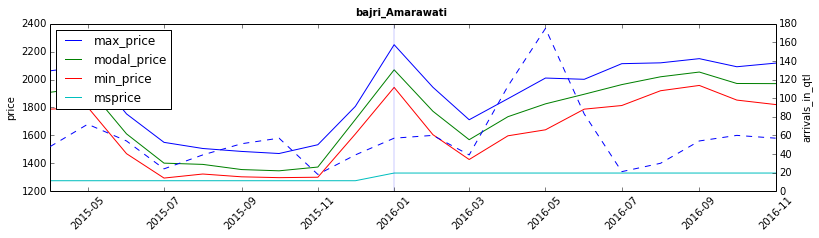

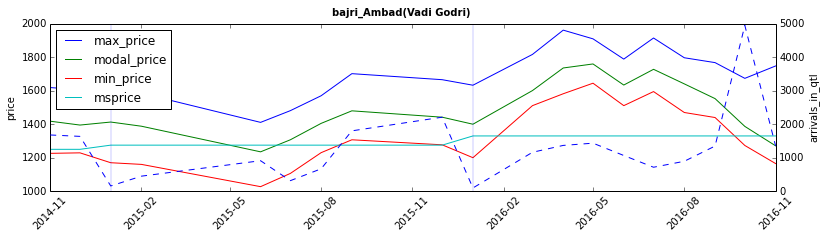

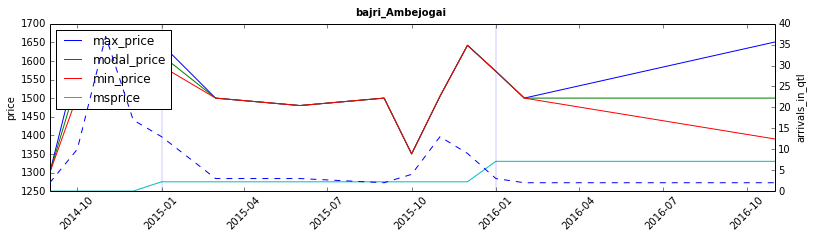

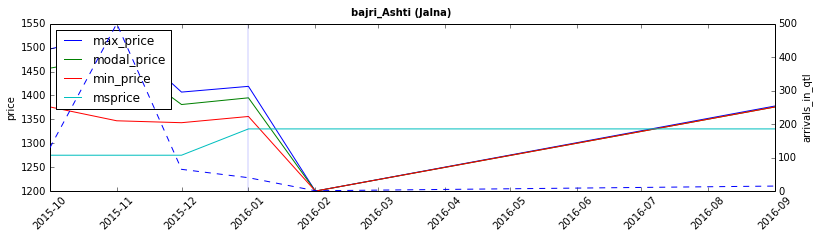

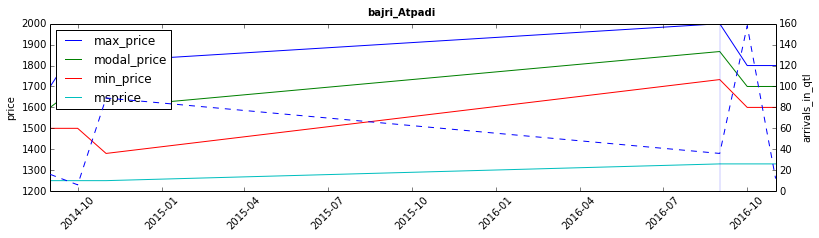

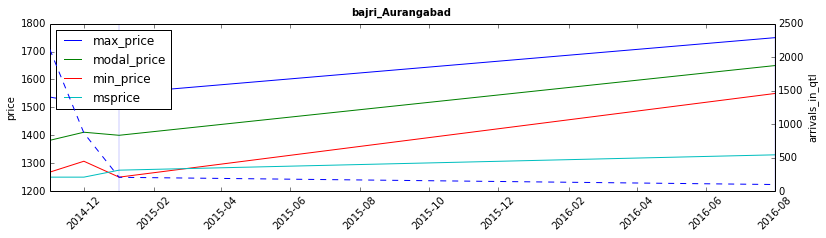

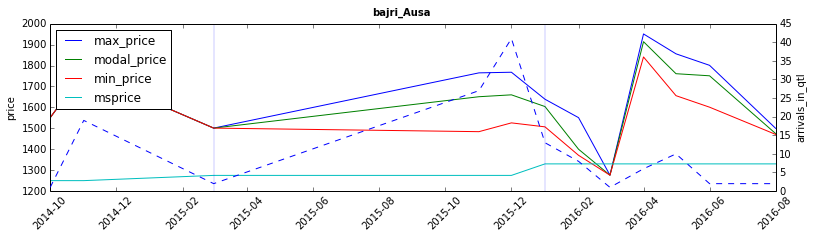

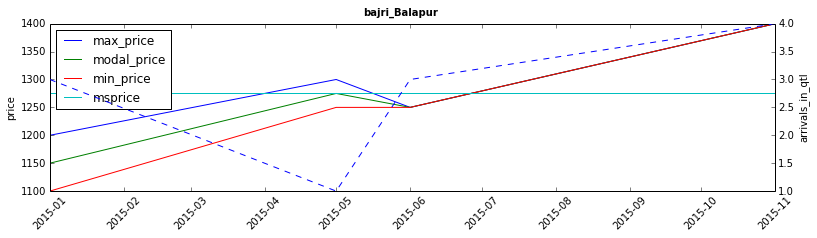

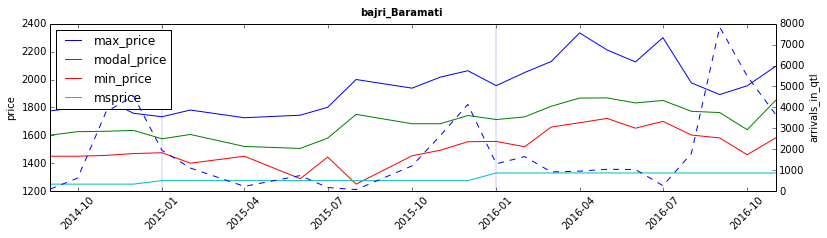

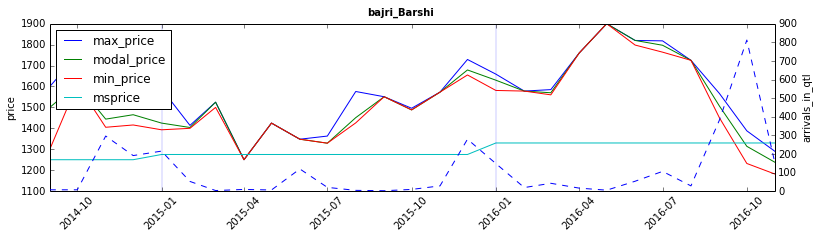

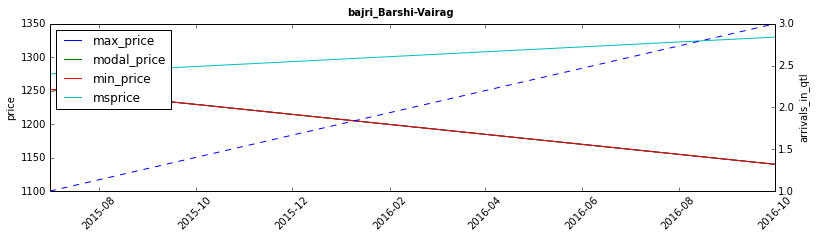

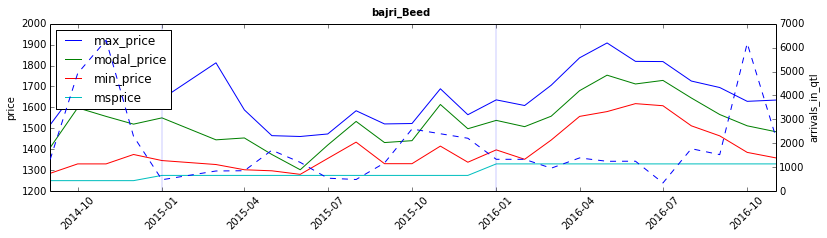

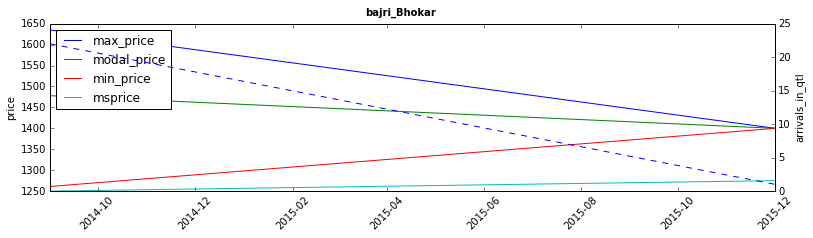

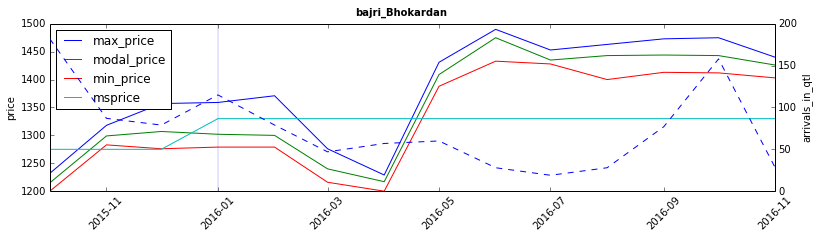

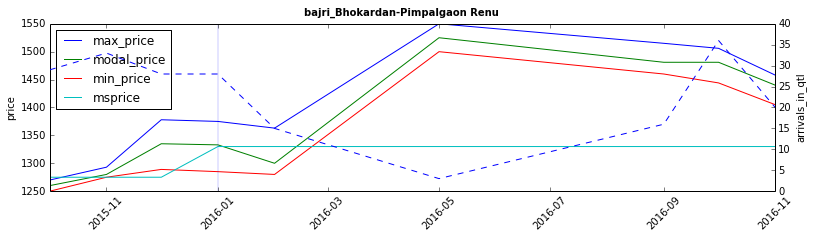

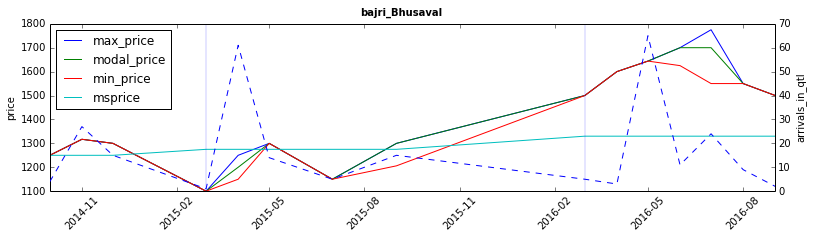

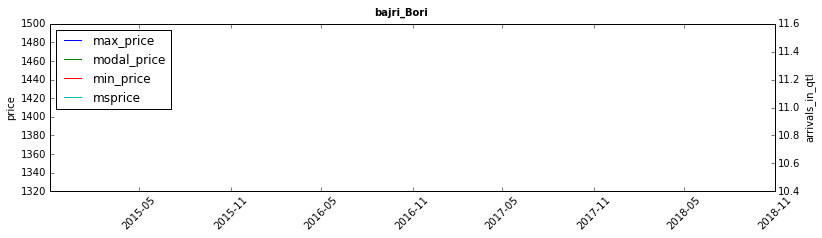

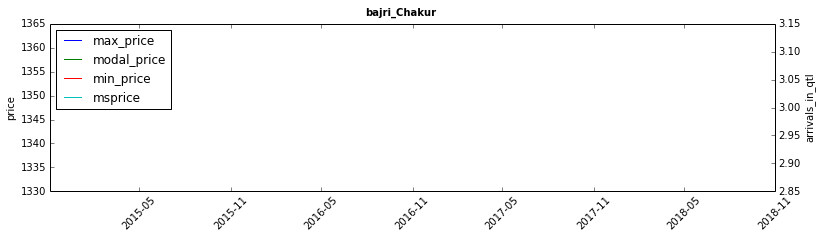

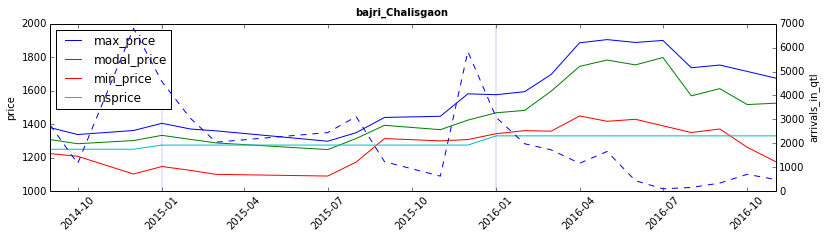

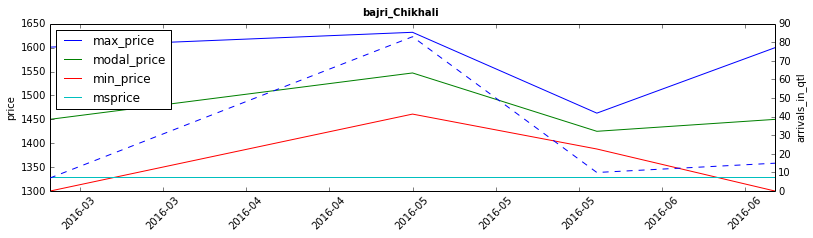

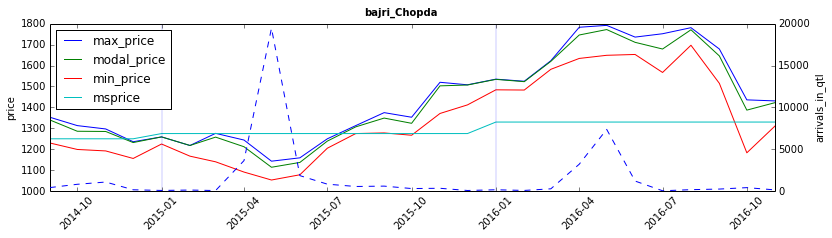

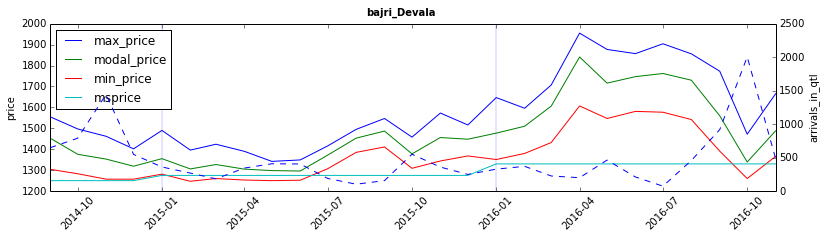

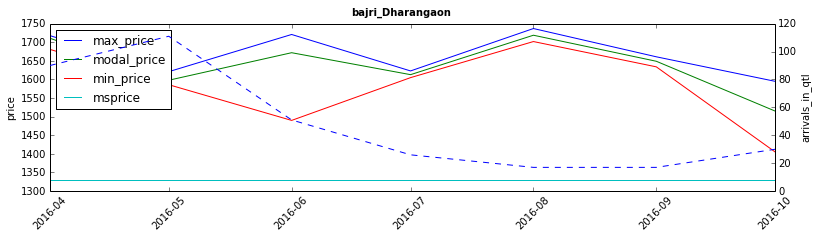

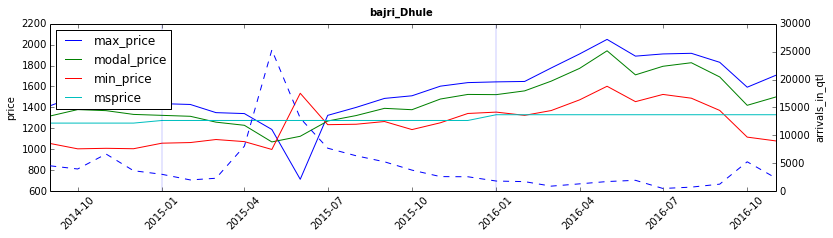

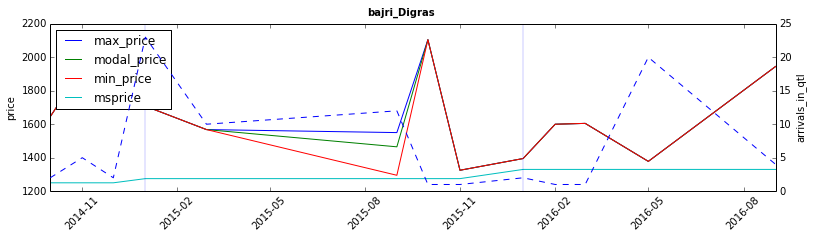

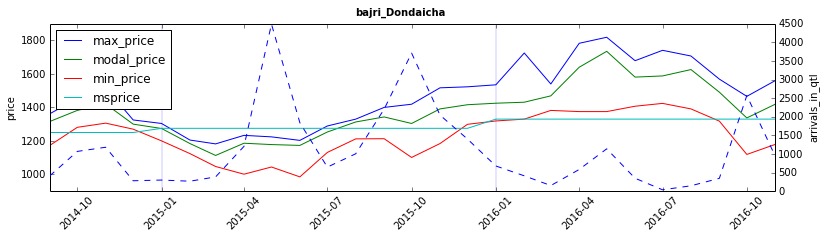

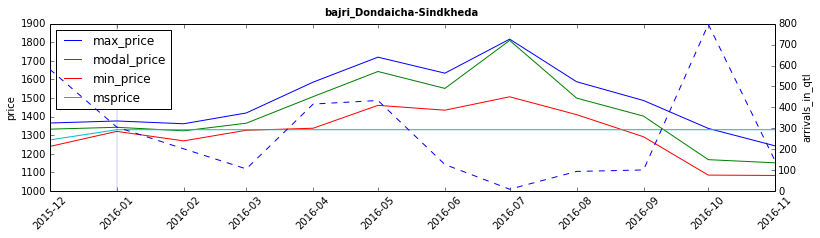

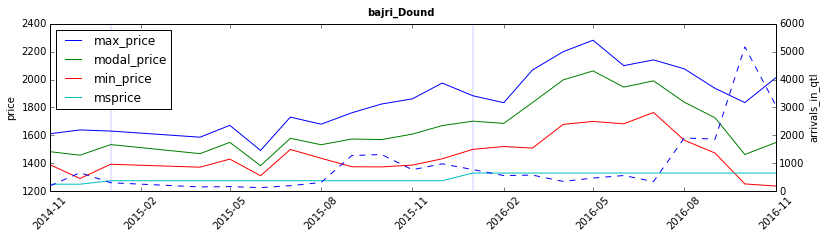

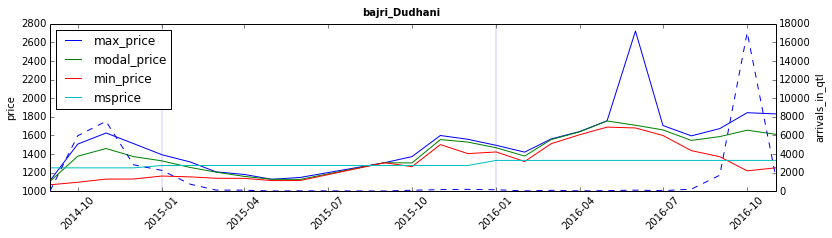

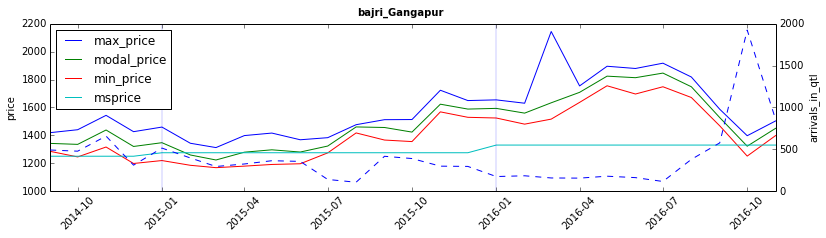

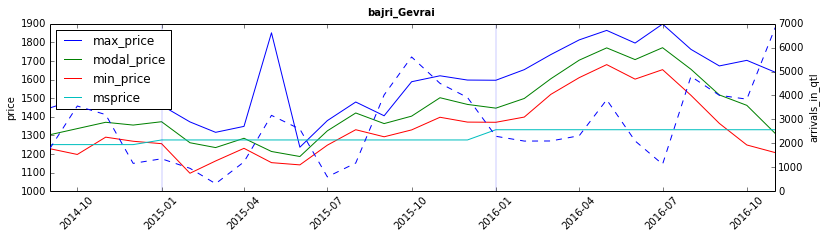

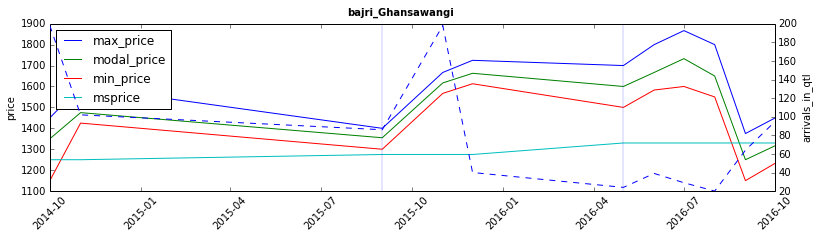

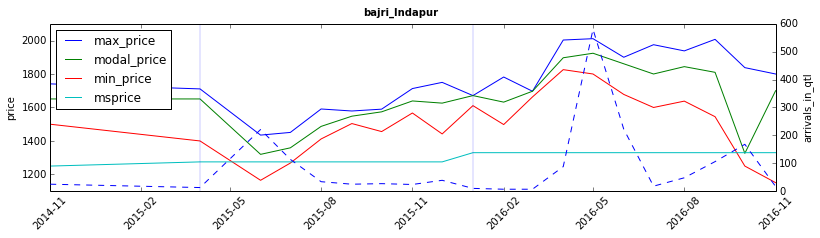

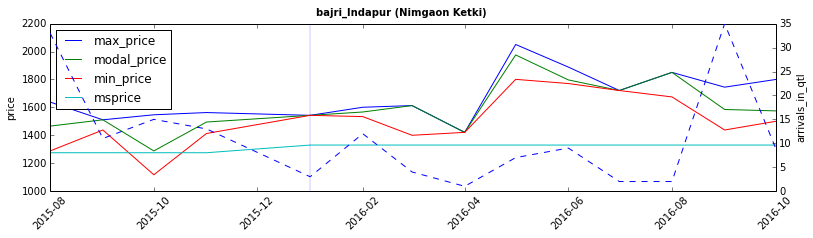

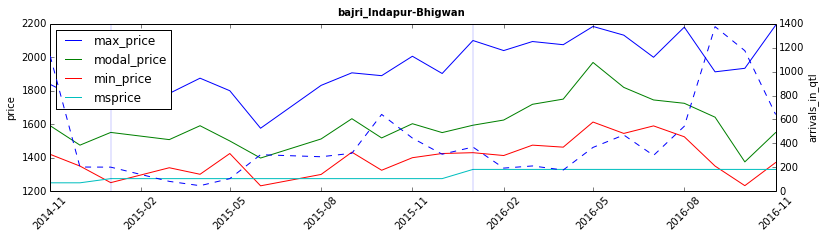

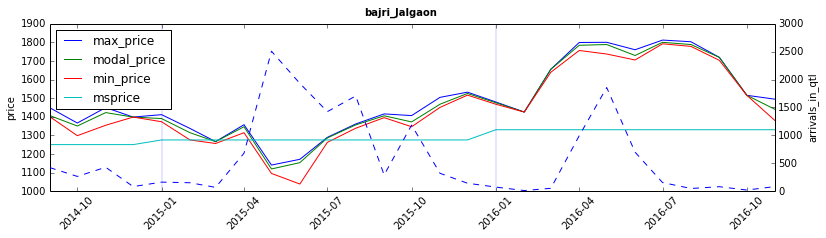

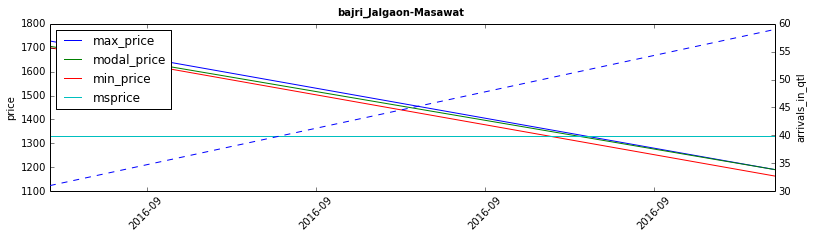

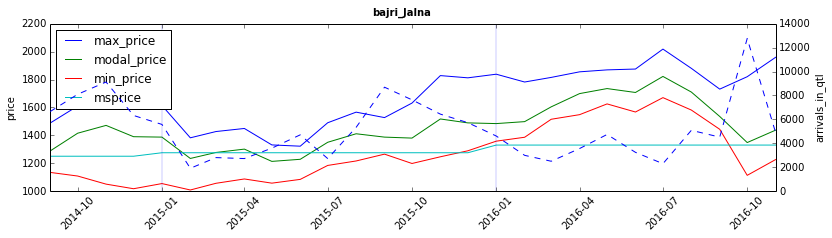

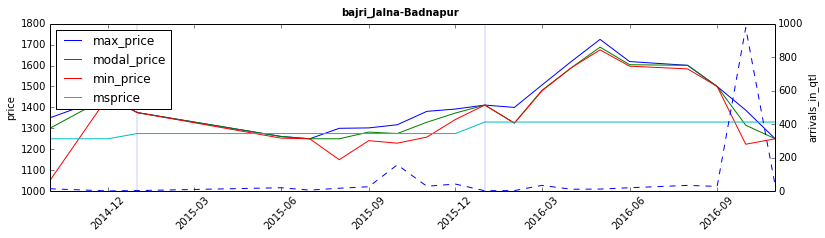

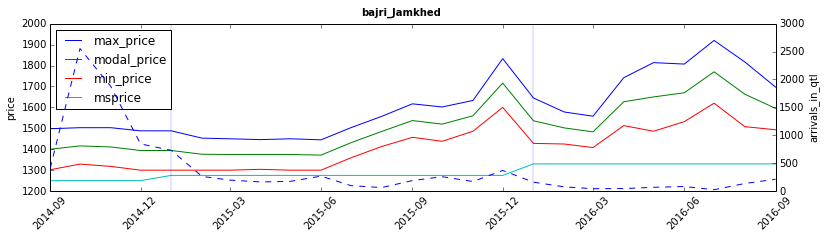

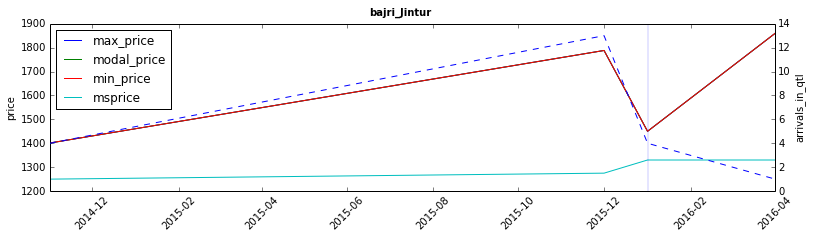

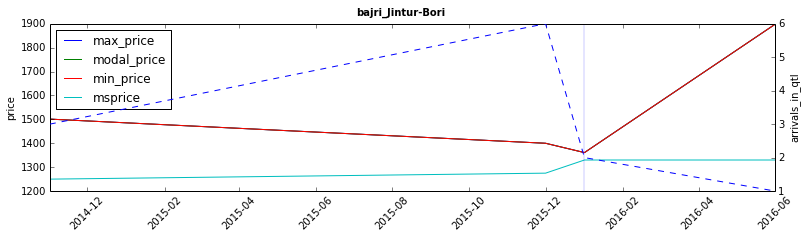

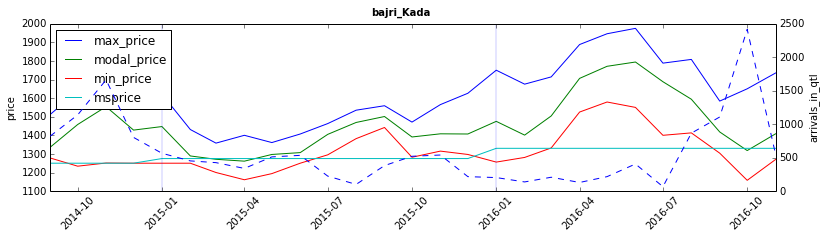

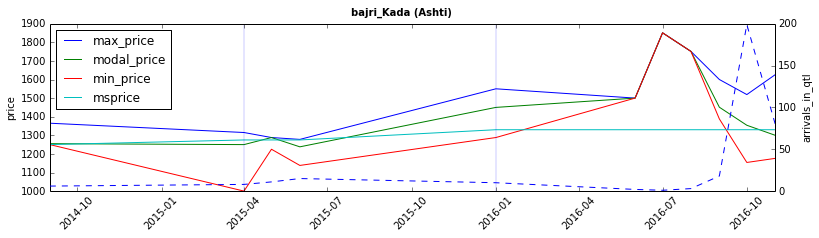

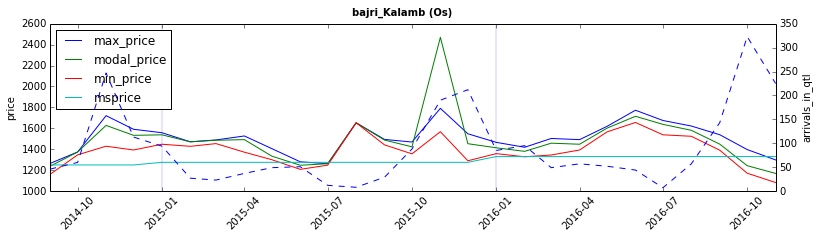

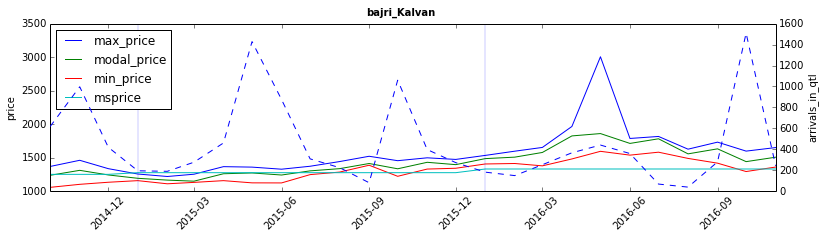

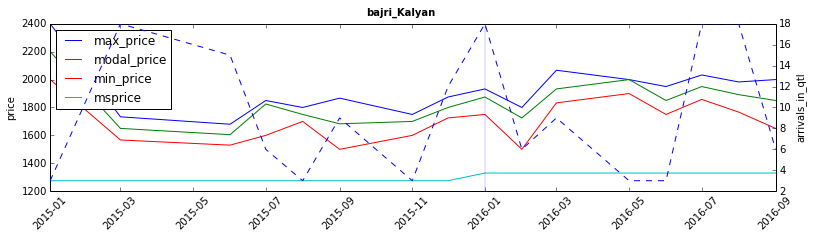

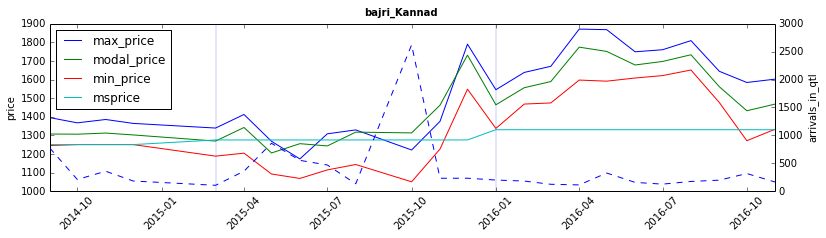

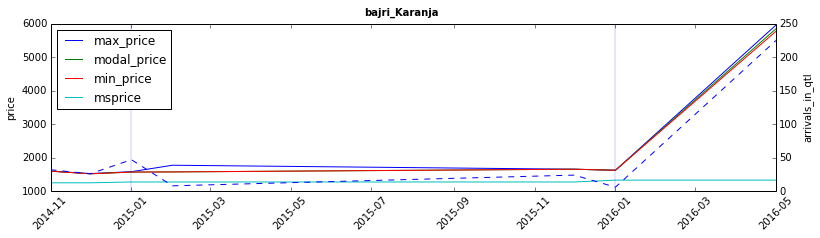

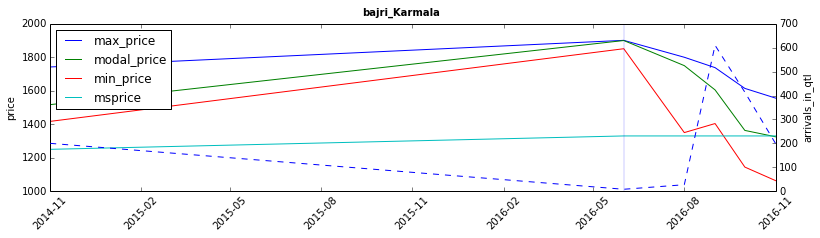

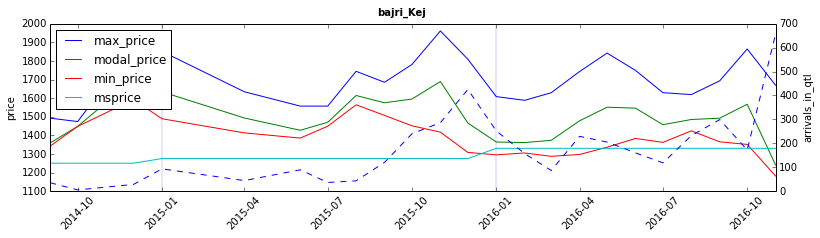

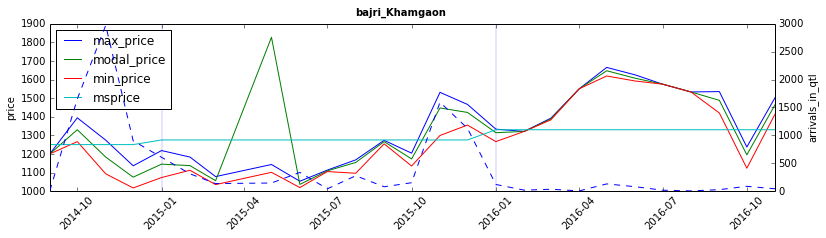

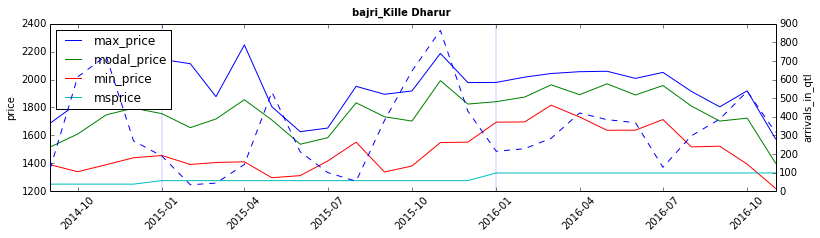

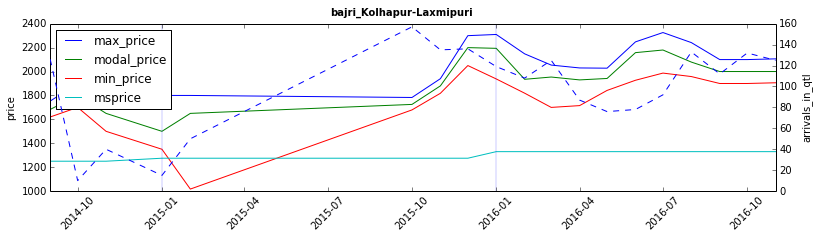

KeyboardInterrupt: 

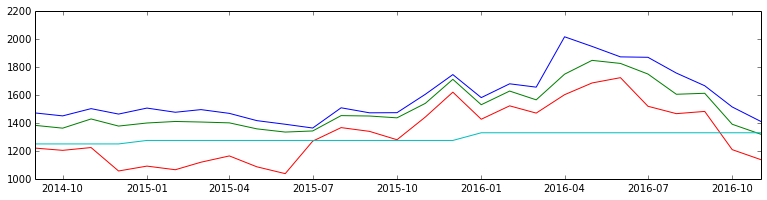

In [267]:
for e in apmc_msp_data.apmc_comd.unique().tolist():
    apmc_comd = apmc_msp_data[apmc_msp_data.apmc_comd == e].sort(['year','monthnum'])
    
    #initialize the plot
    fig = plt.figure(figsize = (13,3))
    ax1 = fig.add_subplot(111)
    xax = plt.gca().get_xaxis()
    xax.set_major_formatter(dt.DateFormatter('%Y-%m'))
    
    #plot the data
    ax1.plot(apmc_comd.date_revised, apmc_comd.max_price)
    ax1.plot(apmc_comd.date_revised, apmc_comd.modal_price)
    ax1.plot(apmc_comd.date_revised, apmc_comd.min_price)
    ax1.plot(apmc_comd.date_revised, apmc_comd.msprice)
    ax2 = ax1.twinx()
    ax2.plot(apmc_comd.date_revised, apmc_comd.arrivals_in_qtl, linestyle='--')
    
    #Plotting vertical to separate different years
    for i in range(1, 12, 1):
        if '2015-0'+str(i) in apmc_comd.date.tolist():
            ax1.axvline(x= '2015-0'+str(i), linewidth = .2)
            break
    for i in range(1, 12, 1):
        if '2016-0'+str(i) in apmc_comd.date.tolist():
            ax1.axvline(x= '2016-0'+str(i), linewidth = .2)
            break
    
    #Setting legends and labels
    ax1.set(ylabel = 'price')
    ax1.legend(['max_price','modal_price','min_price','msprice'], loc = 'upper left')
    ax2.legend(loc= 'upper right')
    ax2.set(ylabel = 'arrivals_in_qtl')
    
    #defining layout of the plot
    fig.suptitle(e, fontsize = 10, fontweight = 'bold')
    for tick in ax1.get_xticklabels():
        tick.set_rotation(45)
    plt.show()



** Insights on the supply and price trend and comparison between mandi price and msprice **
-
-
- 
-
-

### Checking for Seasonality in the prices

Every Time Series dataset has mainly 3 componets a) Trend b) Seasonality (i.e repeatation of a pattern for a fixed period of time; can be additive or multiplicative) c) Noise

If there is trend or seasonality in the data then it is called non stationary data and there are 3 ways to check non stationarity of a dataset:
- Read the time series plot carefully
- Summary of statistics like mean and variance - Divide the data into 2 halves and compare mean and variance of both datasets against each other. This is only useful only if data follows a Gaussian-like distribution
- Statistical test (Dicky Fuller test); needed if the above two ways fail to determine stationarity


** Approach to detect seasonality:**
- Plot ACF of price with itself and indentify periodicity (i.e. the Lag at which maximum autocorrelation occurs)
- Use this periodicity/interval to calculate differenced data
- Detect the type of seasoanlity (Additive/Multiplicative)

** Approach to remove seasonality:**
1. Based on the type of seasonality (additive/multiplicative), apply time sereis decomposition method
2. Time Series Decompostion method will separate trend and seasonality from the data
3. Use the seasonal component to seasonally adjust the original series:
 Additive = Time series - Seasonal; Multiplicative = Time Series/Seasonal



In [268]:
#In India, every commodity thrives in the same weather condition across regions so it is safe to take an average 
#of modal_prices across all apmc for each month in an year
avg_modal_price = apmc_msp_data.groupby(['date_revised','commodity'])['modal_price'].mean().to_frame().reset_index().sort(['commodity','date_revised']).rename(columns = {'modal_price': 'modal_price_mean'})  
#merging average of modal_price across apmc into apmc_msp_data
apmc_msp_data = apmc_msp_data.merge(avg_modal_price, on = ['date_revised','commodity'], how = 'inner')

Time series plot of bajri modal_price for all apmc


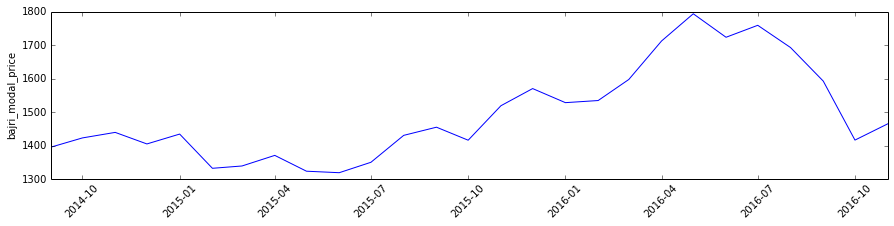

Histogram of bajri modal_price


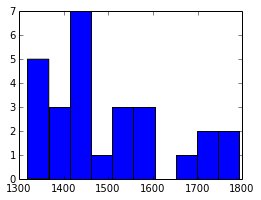

In [286]:
#Lets analyse bajri first by plotting time series and histogram of its modal_price
bajri = avg_modal_price[avg_modal_price.commodity == 'bajri'].sort(['date_revised'])

#initialize the plot
fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(111)
xax = plt.gca().get_xaxis()
xax.set_major_formatter(dt.DateFormatter('%Y-%m'))
    
#Plot the data
ax.plot(bajri.date_revised, bajri.modal_price_mean)

#Put legends etc
ax.set(ylabel ='bajri_modal_price')
plt.xticks(rotation = 45)
print ("Time series plot of bajri modal_price for all apmc")
plt.show()
    
#initialize the plot
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)

print ("Histogram of bajri modal_price")
ax.hist(bajri.modal_price_mean)    
plt.show()

- From the time series plot, we see there is a clear upward trend
- Seasonality may be present, we will find out once we remove the trend
- From the histogram we see that modal_price does not follow Guassian distribution, hence comparison of statistical values (mean and variance) will not be meaningful

So we understand that data is non stationary. To identify seasonal component (if any), we need to remove trend using Differencing method

Post removing trend sometimes data is obviously seasonal (as can be seen in the plot), if not, then autocorrelation coefficient is checked for significance. So, lets plot the differenced chart and autocorrelation plot for every commodity and analyse

#### Removal of Trend and Detecting Seasonality

In [282]:
#Plotting 3 kinds of charts here (diffrenced data, ACF, time series decompostion)
def plot_diffrence_autocorrelation(cmd_apmc, difference_at):
    differenced_data = apmc_msp_data[apmc_msp_data.apmc_comd == cmd_apmc][['modal_price']].diff(periods=int(difference_at))
    
    #1. Plot the differenced data
    print ("1. Differenced data plot")
    #initialise plot
    fig = plt.figure(figsize=(17,2), linewidth=5)
    ax1 = fig.add_subplot(121)
    xax = plt.gca().get_xaxis()
    xax.set_major_formatter(dt.DateFormatter('%Y-%m'))
    ax2 = fig.add_subplot(122)
    xax = plt.gca().get_xaxis()
    xax.set_major_formatter(dt.DateFormatter('%Y-%m'))
    
    #Plot the data 
    ax1.plot(apmc_msp_data[apmc_msp_data.apmc_comd == cmd_apmc].sort(['date']).date_revised, differenced_data)
    ax1.axhline(0, linestyle = '-.', linewidth=1)
    ax2.plot(apmc_msp_data[apmc_msp_data.apmc_comd == cmd_apmc].sort(['date']).date_revised, apmc_msp_data[apmc_msp_data.apmc_comd == cmd_apmc].modal_price)
    
    #Putting title and formatting
    ax1.grid(color='r', linestyle='--', linewidth=0.2)
    ax2.grid(color='r', linestyle='--', linewidth=0.2)
    ax1.set(title = 'Differencing in '+ cmd_apmc +' price')
    ax2.set(title = 'Original Time Series of '+cmd_apmc+' price')
    for tick in ax1.get_xticklabels():
        tick.set_rotation(90)
    for tick in ax2.get_xticklabels():
        tick.set_rotation(90)    
    plt.show()
    
    
    
    #2. Plot the autocorrelation_plot for each commodity
    print ("2. Autocorrelation of "+cmd_apmc+' price')
    plot_acf(apmc_msp_data[apmc_msp_data.apmc_comd == cmd_apmc].modal_price)
    plt.show()


interact(plot_diffrence_autocorrelation, cmd_apmc =  widgets.Dropdown(
    options=apmc_msp_data.apmc_comd.unique().tolist(),
    value='bajri_Ahmednagar',
    description='cmd_apmc:',
    disabled=False,
), difference_at = '5')

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnY21kX2FwbWM6JywgaW5kZXg9MSwgb3B0aW9ucz0oJ2JhanJpX0FjaGFscHVyJywgJ2JhanJpX0FobWVkbmFnYXLigKY=


<function __main__.plot_diffrence_autocorrelation>

From the ACF plot we see that the highest autocorrelation is occuring at interval 5, hence the periodicty of this commodity-apmc combination is 5

We also see that the magnitude of seasonal fluctuations is not changing too much with time, hence seasonality is of additive nature

#### Removal of Seasonality
Steps to remove seasonality:
1. Plot Time series decompostion
2. Extract seasonality component for each commodity apmc cluster
3. Subtract this seasonality component from original time series data: Additive = Time series - Seasonal; Multiplicative = Time Series/Seasonal

Finally, we will compare seasonal/raw and deseasonalised prices with msprice

In [285]:
#Plotting 2 kinds of charts here 1) time series decomposition b) comparison plot
def plot_time_decompostion_graphs(cmd_apmc):
    ts_data = apmc_msp_data[apmc_msp_data.apmc_comd == cmd_apmc][['date_revised','modal_price']].set_index(['date_revised'])#.rename_axis(None, axis = 0)     # ts_data = apmc_msp_data.sort(['apmc_comd','date_revised'])[apmc_msp_data.apmc_comd == com_apmc][['date_revised','modal_price']]
    apmc_comd = apmc_msp_data[apmc_msp_data.apmc_comd == cmd_apmc].sort(['year','monthnum'])
    result_additive = seasonal_decompose(ts_data, model='additive', freq = 5)
    
    #initialize the plot
    print ("1. Time Series Decomposiotn plot, separating Trend, Seasonal component & Noise")
    fig = plt.figure(figsize=(8,7))
    ax1 = fig.add_subplot(411)
    ax2 = fig.add_subplot(412)
    ax3 = fig.add_subplot(413)
    ax4 = fig.add_subplot(414)
    
    xax = plt.gca().get_xaxis()
    xax.set_major_formatter(dt.DateFormatter('%Y-%m'))

    ax1.plot(apmc_comd.date_revised, result_additive.observed)
    ax2.plot(apmc_comd.date_revised, result_additive.trend)
    ax3.plot(apmc_comd.date_revised, result_additive.seasonal)
    ax4.plot(apmc_comd.date_revised, result_additive.resid)

    
    ax1.set(ylabel = 'Observed')
    ax2.set(ylabel = 'Trend')
    ax3.set(ylabel = 'Seasonal')
    ax4.set(ylabel = 'Noise')
    ax1.set_xticks([])
    ax2.set_xticks([])
    ax3.set_xticks([])
    for tick in ax4.get_xticklabels():
            tick.set_rotation(90) 
    plt.show()
    
    print("We see that the seasonal component does not change significantly overtime, hence it is additive in nature, let's use that now to seasonally adjust the data\n")

    #Plotting comparison of Seasonal with msprice and Deseasonal with msprice
    print ("2. Plotting comparison b/w seasonal and deseasonal price with msprice")
    #initialize the plot
    fig = plt.figure(figsize = (15,4))
    ax1 = fig.add_subplot(121)
    xax = plt.gca().get_xaxis()
    xax.set_major_formatter(dt.DateFormatter('%Y-%m'))
    ax2 = fig.add_subplot(122)
    xax = plt.gca().get_xaxis()
    xax.set_major_formatter(dt.DateFormatter('%Y-%m'))

    #Plot the data
    ax1.plot(apmc_comd.date_revised, apmc_comd.modal_price)
    ax1.plot(apmc_comd.date_revised, apmc_comd.msprice)
    ax2.plot(apmc_comd.date_revised, result_additive.observed - result_additive.seasonal)
    ax2.plot(apmc_comd.date_revised, apmc_comd.msprice)

    #Defining legends and labels
    ax1.legend(['Seasonal Price','msprice'])
    ax2.legend(['Desesonalised Price','msprice'])
    for tick in ax1.get_xticklabels():
            tick.set_rotation(90) 
    for tick in ax2.get_xticklabels():
            tick.set_rotation(90)         
    plt.show()
interact(plot_time_decompostion_graphs, cmd_apmc = widgets.Dropdown(
    options=apmc_msp_data.apmc_comd.unique().tolist(),
    value='bajri_Ahmednagar',
    description='cmd_apmc:',
    disabled=False,
))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnY21kX2FwbWM6JywgaW5kZXg9MSwgb3B0aW9ucz0oJ2JhanJpX0FjaGFscHVyJywgJ2JhanJpX0FobWVkbmFnYXLigKY=


<function __main__.plot_time_decompostion_graphs>

### Insights from the above comparison
-
-
-


In [272]:
#Plotting 2 kinds of charts here 1) time series decomposition b) comparison plot
def plot_time_decompostion_graphs(cmd_apmc):
    ts_data = apmc_msp_data[apmc_msp_data.apmc_comd == cmd_apmc][['date_revised','modal_price']].set_index(['date_revised'])#.rename_axis(None, axis = 0) 
    apmc_comd = apmc_msp_data[apmc_msp_data.apmc_comd == cmd_apmc].sort(['year','monthnum'])
    result_additive = seasonal_decompose(ts_data, model='additive', freq = 5)
    result_mutiplicative = seasonal_decompose(ts_data, model='multiplicative', freq = 5)
    
    #initialize the plot
    print ("1. Time Series Decomposiotn plot, separating Trend, Seasonal component & Noise")
    fig, ax = plt.subplots(4, 2, sharex = 'col', figsize = (13,8))
    #Plotting additive model
    ax[0,0].plot(apmc_comd.date_revised, result_additive.observed)
    ax[1,0].plot(apmc_comd.date_revised, result_additive.trend)
    ax[2,0].plot(apmc_comd.date_revised, result_additive.seasonal)
    ax[3,0].plot(apmc_comd.date_revised, result_additive.resid)
    #plotting multiplicative model
    ax[0,1].plot(apmc_comd.date_revised, result_mutiplicative.observed)
    ax[1,1].plot(apmc_comd.date_revised, result_mutiplicative.trend)
    ax[2,1].plot(apmc_comd.date_revised, result_mutiplicative.seasonal)
    ax[3,1].plot(apmc_comd.date_revised, result_mutiplicative.resid)
    
    ax[0,0].set(title = 'Additive Model')
    ax[0,0].set(ylabel = 'Observed')
    ax[1,0].set(ylabel = 'Trend')
    ax[2,0].set(ylabel = 'Seasonal')
    ax[3,0].set(ylabel = 'Noise')
    ax[0,1].set(title = 'Mutiplicative Model')
    ax[0,1].set(ylabel = 'Observed')
    ax[1,1].set(ylabel = 'Trend')
    ax[2,1].set(ylabel = 'Seasonal')
    ax[3,1].set(ylabel = 'Noise')
    ax[0,0].set_xticks([])
    ax[1,0].set_xticks([])
    ax[2,0].set_xticks([])
    for tick in ax[3,0].get_xticklabels():
            tick.set_rotation(90) 
    ax[0,1].set_xticks([])
    ax[1,1].set_xticks([])
    ax[2,1].set_xticks([])
    for tick in ax[3,1].get_xticklabels():
            tick.set_rotation(90)         
    plt.show()

    print("We note differences in the scale of the decomposed time series when compared to the multiplicative model. There is still a pattern left in the residual series. The high residual values of the additive decomposition indicate that the application of a multiplicative model is preferable.\n\n")
    
    #Plotting comparison of Seasonal with msprice and Deseasonal with msprice
    print ("2. Comparison b/w raw & msprice and deseasonalised & msprice ")
    #initialize the plot
    fig = plt.figure(figsize = (15,4))
    ax1 = fig.add_subplot(121)
    xax = plt.gca().get_xaxis()
    xax.set_major_formatter(dt.DateFormatter('%Y-%m'))
    ax2 = fig.add_subplot(122)
    xax = plt.gca().get_xaxis()
    xax.set_major_formatter(dt.DateFormatter('%Y-%m'))

    #Plot the data
    ax1.plot(apmc_comd.date_revised, apmc_comd.modal_price)
    ax1.plot(apmc_comd.date_revised, apmc_comd.msprice)
    if max(result_mutiplicative.resid) < max(result_additive.resid):
        ax2.plot(apmc_comd.date_revised, result_mutiplicative.observed/result_mutiplicative.seasonal)
    else:
        ax2.plot(apmc_comd.date_revised, result_additive.observed - result_additive.seasonal)
    ax2.plot(apmc_comd.date_revised, apmc_comd.msprice)

    #Defining legends and labels
    ax1.legend(['Raw Price','msprice'])
    ax2.legend(['Desesonalised Price','msprice'])
    for tick in ax1.get_xticklabels():
            tick.set_rotation(90) 
    for tick in ax2.get_xticklabels():
            tick.set_rotation(90)         
    plt.show()
interact(plot_time_decompostion_graphs, cmd_apmc = widgets.Dropdown(
    options=apmc_msp_data.apmc_comd.unique().tolist(),
    value='bajri_Ahmednagar',
    description='cmd_apmc:',
    disabled=False,
))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnY21kX2FwbWM6JywgaW5kZXg9MSwgb3B0aW9ucz0oJ2JhanJpX0FjaGFscHVyJywgJ2JhanJpX0FobWVkbmFnYXLigKY=


<function __main__.plot_time_decompostion_graphs>

In [273]:
# apmc_msp_data['date_revised'] = apmc_msp_data[['date']].applymap(lambda x: datetime.strptime(x, '%Y-%d'))
# apmc_msp_data['date_revised'] = pd.to_datetime(apmc_msp_data['date'])

# apmc_msp_data['date_revised'] = apmc_msp_data[['date']].applymap(lambda x: pd.Period(x))
# apmc_msp_data['date_revised'] = apmc_msp_data[['date_revised']].applymap(lambda x: x.asfreq('M'))
# apmc_msp_data['date_revised'] = apmc_msp_data[['date_revised']].applymap(lambda x: x.to_timestamp(freq = 'M'))
apmc_msp_data['date_revised'][0]

Period('2015-01', 'M')

In [274]:
# period = pd.Period(apmc_msp_data['date'][0])
# apmc_msp_data['date_revised'] = apmc_msp_data[['date']].applymap(lambda x: pd.Period(x))

apmc_msp_data['date_revised'][0]

Period('2015-01', 'M')

In [275]:

ts_data = apmc_msp_data[apmc_msp_data.apmc_comd == 'bajri_Ahmednagar'][['date_revised','modal_price']].set_index(['date_revised'])#.rename_axis(None, axis = 1)
# ts_data.loc[-1] = ['2015-05-31', 4]
# ts_data.index = pd.DatetimeIndex(ts_data['date_revised'], freq='M')
# ts_data = ts_data.set_index(['date_revised'])
ts_data.index


<class 'pandas.tseries.period.PeriodIndex'>
[2015-01, ..., 2015-12]
Length: 23, Freq: M